In [1]:
import networkx as nx
from networkx.algorithms import community as com
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
from operator import itemgetter
import scipy.stats as stats

In [3]:
with open('./data/autori_cleaned', 'rb') as file:
    autori = pd.read_pickle(file)
with open('./data/data_cleaned', 'rb') as file:
    data = pd.read_pickle(file)

In [4]:
print(autori.head())
print(data.head())

          Ime            Prezime                    Katedra  H indeks  \
0       tanja          jovanovic  katedra za mikrobiologiju        11   
1  branislava              savic  katedra za mikrobiologiju        10   
2       sanja           mitrovic  katedra za mikrobiologiju         4   
3       lazar              ranin  katedra za mikrobiologiju         7   
4   valentina  arsic-arsenijevic  katedra za mikrobiologiju        17   

   Broj radova  id                     Puno ime              Skraceno  
0           45   0              tanja jovanovic          jovanovic t.  
1           30   1             branislava savic              savic b.  
2           20   2               sanja mitrovic           mitrovic s.  
3           40   3                  lazar ranin              ranin l.  
4           52   4  valentina arsic-arsenijevic  arsic-arsenijevic v.  
                    Author                                              Title  \
0  jasmina simonovic-babic  state of viral hepat

In [5]:
G = nx.Graph()
for _,row in autori.iterrows():
    G.add_node(row['Puno ime'], katedra=row['Katedra'])

In [6]:
from itertools import combinations

title_grouped = data.groupby('Title')['Author']
for _,authors in title_grouped:
    author_list = authors.tolist()
    author_pairs = combinations(author_list,2)
    for autor1,autor2 in author_pairs:
        if (autor1, autor2) in G.edges:
            G.edges[autor1,autor2]['weight'] += 1
        else:
            G.add_edge(autor1, autor2, weight=1)

In [43]:
print(G.edges.data("weight"))

[('tanja jovanovic', 'goran stevanovic', 16), ('tanja jovanovic', 'maja cupic', 88), ('tanja jovanovic', 'ivana lazarevic', 84), ('tanja jovanovic', 'ana banko', 52), ('tanja jovanovic', 'aleksandra knezevic', 52), ('tanja jovanovic', 'maja stanojevic', 24), ('tanja jovanovic', 'slobodanka djukic', 4), ('tanja jovanovic', 'jovan ranin', 4), ('tanja jovanovic', 'tatjana pekmezovic', 4), ('tanja jovanovic', 'vera pravica', 8), ('branislava savic', 'dragana vukovic', 52), ('branislava savic', 'ivana dakic', 32), ('branislava savic', 'irena arandjelovic', 16), ('branislava savic', 'lazar ranin', 4), ('branislava savic', 'jovan ranin', 4), ('branislava savic', 'ivana cirkovic', 4), ('branislava savic', 'vera mijac', 4), ('sanja mitrovic', 'valentina arsic-arsenijevic', 40), ('sanja mitrovic', 'aleksandar dzamic', 48), ('sanja mitrovic', 'ivana colovic-colovski', 4), ('sanja mitrovic', 'dusan popadic', 4), ('sanja mitrovic', 'isidora vujcic', 4), ('sanja mitrovic', 'eleonora dubljanin', 8), 

In [36]:
output_path="models/undirected_papper_colaboration.gml"
nx.write_gml(G, output_path)

In [7]:
# Calculate density
density = nx.density(G)
print(f'Network Density: {density}')

Network Density: 0.1748911465892598


In [8]:
avg_distance = nx.average_shortest_path_length(G)
print(f'Average Distance: {avg_distance}')

Average Distance: 2.3570391872278664


In [9]:
diameter = nx.diameter(G)
print(f'Diameter: {diameter}')

Diameter: 5


In [10]:
if nx.is_connected(G):
    num_components = 1
    component_sizes = [len(G.nodes)]
else:
    components = list(nx.connected_components(G))
    num_components = len(components)
    component_sizes = [len(component) for component in components]

print(f'Number of Connected Components: {num_components}')
print(f'Size of Each Component: {component_sizes}')

Number of Connected Components: 1
Size of Each Component: [53]


Imam jednu dzinovsku komponentu?

In [11]:
if nx.is_connected(G):
    # For connected graph, number of connected components is 1
    num_components = 1
    component_sizes = [len(G.nodes)]
else:
    # For disconnected graph
    components = list(nx.connected_components(G))
    num_components = len(components)
    component_sizes = [len(component) for component in components]

print(f'Number of Connected Components: {num_components}')
print(f'Size of Each Component: {component_sizes}')

Number of Connected Components: 1
Size of Each Component: [53]


In [12]:
def calculate_centralities(G):

    DC_dict = nx.degree_centrality(G)
    CC_dict = nx.closeness_centrality(G)
    BC_dict = nx.betweenness_centrality(G)
    EVC_dict = nx.eigenvector_centrality(G)

    df1 = pd.DataFrame.from_dict(DC_dict, orient='index', columns=['DC'])
    df2 = pd.DataFrame.from_dict(CC_dict, orient='index', columns=['CC'])
    df3 = pd.DataFrame.from_dict(BC_dict, orient='index', columns=['BC'])
    df4 = pd.DataFrame.from_dict(EVC_dict, orient='index', columns=['EVC'])
    df = pd.concat([df1, df2, df3, df4], axis=1)
    return df

In [48]:
df = calculate_centralities(G)
print(df)

                                      DC        CC        BC       EVC
tanja jovanovic                 0.192308  0.504854  0.028419  0.141412
branislava savic                0.134615  0.400000  0.007689  0.053655
sanja mitrovic                  0.153846  0.452174  0.057838  0.044523
lazar ranin                     0.230769  0.440678  0.058853  0.100766
valentina arsic-arsenijevic     0.134615  0.444444  0.032813  0.044053
slobodanka djukic               0.173077  0.485981  0.025996  0.102227
maja cupic                      0.288462  0.514851  0.065122  0.184637
natasa vuckovic-opavski         0.019231  0.307692  0.000000  0.009229
aleksandar dzamic               0.173077  0.477064  0.057653  0.071758
dragana vukovic                 0.230769  0.456140  0.049766  0.090203
ivana dakic                     0.134615  0.385185  0.004168  0.051220
aleksandra knezevic             0.192308  0.514851  0.030857  0.137538
ivana lazarevic                 0.365385  0.553191  0.171774  0.303525
maja s

In [13]:
# Calculate centralization
def centralization(G):
    centralities = nx.degree_centrality(G)
    max_centrality = max(centralities.values())
    centralization = sum(max_centrality - c for c in centralities.values()) / ((len(G) - 1) * (len(G) - 2))
    return centralization

centralization_value = centralization(G)
print(f'Centralization: {centralization_value:.4f}')

Centralization: 0.0038


In [14]:
# Global Clustering Coefficient (Transitivity)
global_clustering_coefficient = nx.transitivity(G)
print(f'Global Clustering Coefficient (Transitivity): {global_clustering_coefficient}')

# Average Clustering Coefficient
average_clustering_coefficient = nx.average_clustering(G)
print(f'Average Clustering Coefficient: {average_clustering_coefficient}')

# Local Clustering Coefficient Distribution
local_clustering_coefficients = nx.clustering(G).values()

Global Clustering Coefficient (Transitivity): 0.5450928381962865
Average Clustering Coefficient: 0.6005288212835382


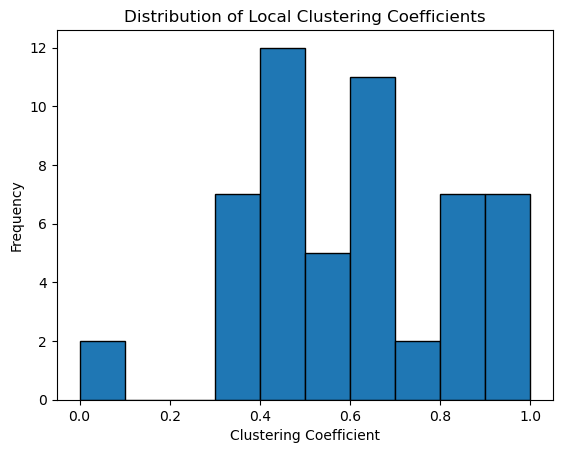

In [15]:
# 2. Plot the distribution of local clustering coefficients
plt.hist(local_clustering_coefficients, bins=10, edgecolor='black')
plt.title('Distribution of Local Clustering Coefficients')
plt.xlabel('Clustering Coefficient')
plt.ylabel('Frequency')
plt.show()

In [24]:
# Erdos-Renyi Random Graph
n = G.number_of_nodes()
p = nx.density(G)  # Use the density of your graph as the probability
G_erdos = nx.erdos_renyi_graph(n, p)

In [27]:
# Scale-Free Network
G_scale_free_multi = nx.scale_free_graph(n)
G_scale_free = nx.Graph(G_scale_free_multi)

In [29]:
# Calculate clustering coefficients for comparison
average_clustering_erdos = nx.average_clustering(G_erdos)
average_clustering_scale_free = nx.average_clustering(G_scale_free)
transitivity_erdos = nx.transitivity(G_erdos)
transitivity_scale_free = nx.transitivity(G_scale_free)

print(f'Erdos-Renyi Average Clustering Coefficient: {average_clustering_erdos}')
print(f'Erdos-Renyi Global Clustering Coefficient: {transitivity_erdos}')
print(f'Scale-Free Average Clustering Coefficient: {average_clustering_scale_free}')
print(f'Scale-Free Global Clustering Coefficient: {transitivity_scale_free}')

Erdos-Renyi Average Clustering Coefficient: 0.19916781331875671
Erdos-Renyi Global Clustering Coefficient: 0.20329024676850763
Scale-Free Average Clustering Coefficient: 0.1319670353502494
Scale-Free Global Clustering Coefficient: 0.06351791530944625


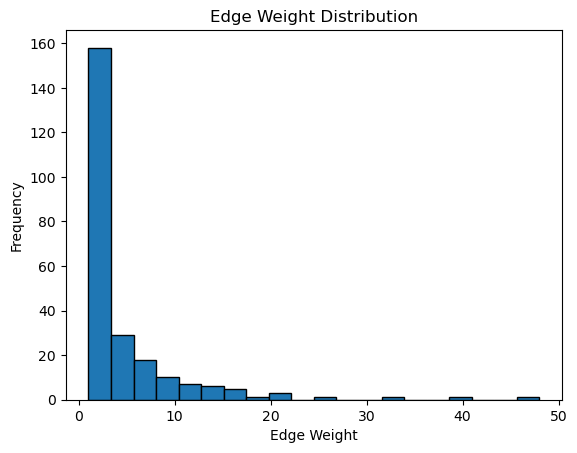

In [30]:
# 1. Edge Weight Distribution
weights = [data['weight'] for u, v, data in G.edges(data=True)]
plt.hist(weights, bins=20, edgecolor='black')
plt.title('Edge Weight Distribution')
plt.xlabel('Edge Weight')
plt.ylabel('Frequency')
plt.show()


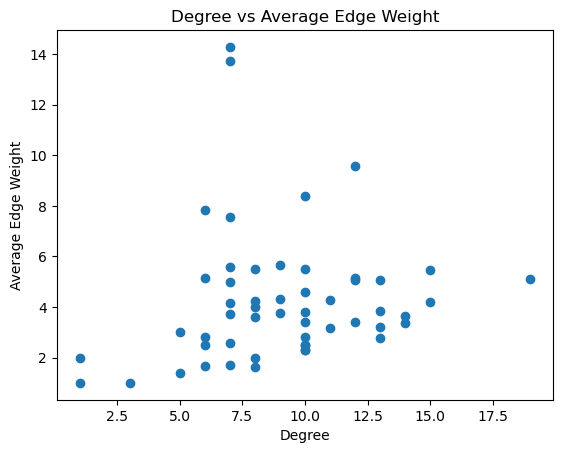

In [33]:
# 2. Degree vs. Average Edge Weight
degrees = dict(G.degree())
strengths = dict(G.degree(weight='weight'))
avg_edge_weights = {node: strengths[node] / degrees[node] for node in G.nodes()}
plt.scatter(degrees.values(), avg_edge_weights.values())
plt.title('Degree vs Average Edge Weight')
plt.xlabel('Degree')
plt.ylabel('Average Edge Weight')
plt.show()


In [34]:
assortativity_coefficient = nx.degree_assortativity_coefficient(G)
print(f'Degree Assortativity Coefficient: {assortativity_coefficient}')

Degree Assortativity Coefficient: 0.04567166142802434


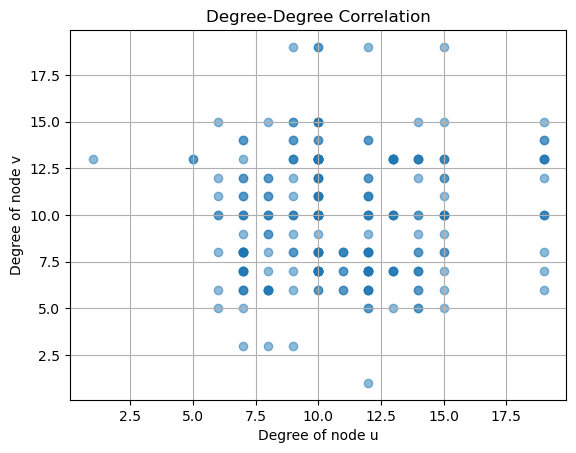

In [35]:
degrees = dict(G.degree())
x, y = zip(*[(degrees[u], degrees[v]) for u, v in G.edges()])

plt.scatter(x, y, alpha=0.5)
plt.title('Degree-Degree Correlation')
plt.xlabel('Degree of node u')
plt.ylabel('Degree of node v')
plt.grid(True)
plt.show()

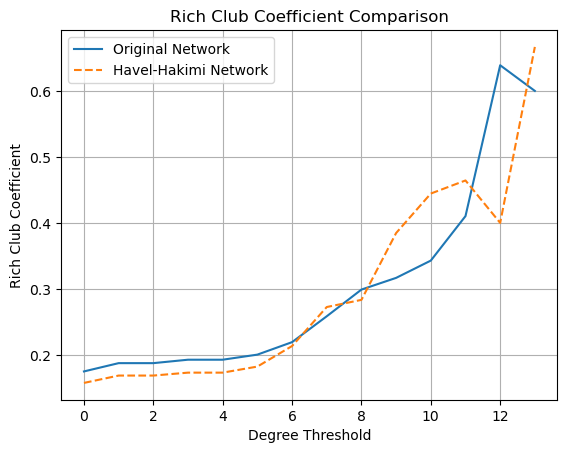

In [38]:
rich_club_coefficient_original = nx.rich_club_coefficient(G, normalized=False)

# 2. Generate a Randomized Network Using the Havel-Hakimi Algorithm
degree_sequence = sorted((d for n, d in G.degree()), reverse=True)
G_havel_hakimi_d = nx.configuration_model(degree_sequence)  # Creates a MultiGraph
G_havel_hakimi = nx.Graph(G_havel_hakimi)  # Convert to simple Graph
G_havel_hakimi.remove_edges_from(nx.selfloop_edges(G_havel_hakimi))  # Remove self-loops
rich_club_coefficient_havel_hakimi = nx.rich_club_coefficient(G_havel_hakimi, normalized=False)

degrees = sorted(set(rich_club_coefficient_original.keys()) & set(rich_club_coefficient_havel_hakimi.keys()))

original_values = [rich_club_coefficient_original[d] for d in degrees]
havel_hakimi_values = [rich_club_coefficient_havel_hakimi[d] for d in degrees]

plt.plot(degrees, original_values, label='Original Network')
plt.plot(degrees, havel_hakimi_values, label='Havel-Hakimi Network', linestyle='--')
plt.xlabel('Degree Threshold')
plt.ylabel('Rich Club Coefficient')
plt.title('Rich Club Coefficient Comparison')
plt.legend()
plt.grid(True)
plt.show()


In [42]:
# 1. Calculate degree sequence
degree_sequence = [d for n, d in G.degree()]
degree_count = np.bincount(degree_sequence)
degrees = np.arange(len(degree_count))


In [43]:
import powerlaw
fit = powerlaw.Fit(degree_sequence, xmin=1, discrete=True)
alpha = fit.power_law.alpha
print(f"Power law exponent: {alpha}")


ModuleNotFoundError: No module named 'powerlaw'

In [ ]:
plt.figure(figsize=(10, 6))
plt.loglog(degrees[degrees > 0], degree_count[degrees > 0], marker='o', linestyle='None', label='Degree Distribution')
plt.loglog(fit.xmin, fit.power_law.pdf(fit.xmin) * fit.power_law.scaling * (degrees[degrees > 0]**-alpha), 'r--', label=f'Power Law Fit\nα = {alpha:.2f}')
plt.title("Degree Distribution and Power Law Fit")
plt.xlabel("Degree (k)")
plt.ylabel("Number of Nodes")
plt.legend()
plt.grid(True)
plt.show()